# Deep Q-Network
Solve a maze using a neural network and Bellman's equation

$Q(s, a) = R + \gamma * max_i(Q(s', a_i))$
- $Q$ the neural network
- $s, a$ state, action (aka. the maze and the position)
- $R$ the reward of taking action $a$ from state $s$
- $\gamma$ a decay rate for future rewards
- $s'$ the new state we arrived at after taking action $a$

Note: if a state is terminal (e.g. hitting a wall, or finding the exit) the formula becomes
$Q(s, a) = R$

In [699]:
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

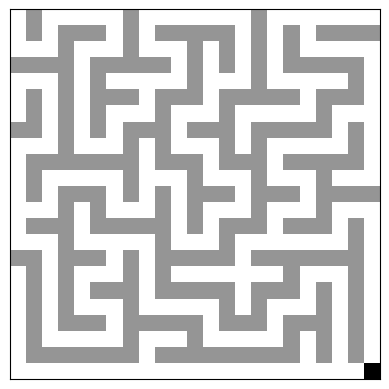

_@_____@_______@_______
_@_@@@_@_@@@@@_@_@_@@@@
___@___@___@_@_@_@_____
@@@@_@@@@@_@_@_@_@@@@@_
___@_@_____@___@_____@_
_@_@_@@@_@@@_@@@@@_@@@_
_@_@_@___@___@_____@___
@@_@_@_@@@_@@@_@@@@@_@_
___@___@_@___@_@_____@_
_@@@@@@@_@@@_@@@_@@@@@_
_@_____@___@___@___@___
_@_@@@_@_@_@@@_@@@_@@@@
___@_@___@_@___@___@___
_@@@_@@@@@_@_@@@_@@@_@_
___@_____@___@_______@_
@@_@@@_@_@@@@@_@@@@@@@_
_@_@___@_@_______@___@_
_@_@_@@@_@@@@@_@@@_@_@_
_@_@___@_____@_@___@_@_
_@_@@@_@@@@@_@@@_@@@_@_
_@_____@___@_____@_@_@_
_@@@@@@@_@@@@@@@@@_@_@_
______________________x


In [610]:
# maze generator
def make_maze(width):
    maze = torch.zeros((width, width))
    moves = list(MOVES.keys())

    def add_exit(maze):
        choices = (maze == 1).nonzero().tolist()
        furthest = max(choices, key=lambda x: x[0] + x[1])
        maze[furthest[0], furthest[1]] = -1

    def rec(x, y):
        while True:
            pairs = []
            for move in moves:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 1, 1
            rec(nnx, nny)

    maze[0, 0] = 1
    rec(0, 0)
    add_exit(maze)
    return maze

def ascii_maze(maze):
    lookup = {0: '@', 1: '_', -1: 'x'}
    print('\n'.join(''.join(lookup[i] for i in row) for row in maze.tolist()))

def plot_maze(maze):
    plt.imshow(-maze, 'Greys')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

# look at the maze
maze = make_maze(23)
plot_maze(maze)
ascii_maze(maze)

In [724]:
# helper functions
@torch.no_grad()
def plot_policy(model, maze):
    dirs = {
        0: '↑',
        1: '↓',
        2: '←',
        3: '→',
    }
    fig, ax = plt.subplots()
    ax.imshow(-maze, 'Greys')
    for pos in (maze == 1).nonzero().tolist():
        q = model(to_input(maze, pos))
        action = int(torch.argmax(q).detach().cpu().item())
        dir = dirs[action]
        ax.text(pos[1] - 0.3, pos[0] + 0.3, dir) # center arrows in empty slots
    
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

# plot_policy(model, default_maze)

In [677]:
default_maze = torch.tensor([
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
    [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, -1],
])

MAZE_WIDTH = default_maze.shape[0]
INPUT_SIZE = MAZE_WIDTH * MAZE_WIDTH + 2 * MAZE_WIDTH
MOVES = {
    (-1, 0): torch.tensor(0).to(device), # up
    (1, 0):  torch.tensor(1).to(device), # down
    (0, -1): torch.tensor(2).to(device), # left
    (0, 1):  torch.tensor(3).to(device),  # right
 }

# policy
HIT_WALL_PENALTY = -1
MOVE_PENALTY = 0
WIN_REWARD = 10
 
# hyperparams
METHOD = 'exhaustive_search'
GAMMA_DECAY = 0.95
HIDDEN_SIZE = INPUT_SIZE
EPOCH = 1000
BATCH_SIZE = 512
LEARNING_RATE = 1e-3

def get_maze():
    maze = default_maze
    # maze = make_maze(MAZE_WIDTH)
    rewards = torch.zeros_like(maze)
    rewards[maze == 0] = HIT_WALL_PENALTY
    rewards[maze == 1] = MOVE_PENALTY
    rewards[maze == -1] = WIN_REWARD
    return maze, rewards

def get_reward(rewards, pos):
    x, y = pos
    a, b = rewards.shape
    if 0 <= x < a and 0 <= y < b:
        return rewards[x, y]
    return HIT_WALL_PENALTY

def get_next_pos(maze, rewards, pos, move):
    is_terminal = True
    new_pos = pos # default to forbidden move.
    reward = HIT_WALL_PENALTY # default to hitting a wall.
    x, y = pos
    a, b = maze.shape
    i, j = move
    if 0 <= x + i < a and 0 <= y + j < b:
        new_pos = (x + i, y + j)
        reward = get_reward(rewards, new_pos)
        is_terminal = maze[new_pos] != 1
    return new_pos, reward, move, is_terminal

def get_batch_randomized():
    batch = []
    maze, rewards = get_maze()
    positions = random.choices((maze == 1).nonzero().tolist(), k=BATCH_SIZE)
    for pos in positions:
        new_pos, reward, move, is_terminal = get_next_pos(maze, rewards, pos, random.choice(list(MOVES.keys())))
        batch.append((pos, move, new_pos, reward, is_terminal))
    return maze, batch

def get_batch_exhaustive_search():
    batch = []
    maze, rewards = get_maze()
    for pos in (maze == 1).nonzero().tolist():
        for mm in list(MOVES.keys()):
            new_pos, reward, move, is_terminal = get_next_pos(maze, rewards, pos, mm)
            batch.append((pos, move, new_pos, reward, is_terminal))
    return maze, batch

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, len(MOVES)),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)        
        return logits

def to_input(maze, pos):
    return torch.cat((
        maze.view(-1),
        F.one_hot(torch.tensor(pos), num_classes=MAZE_WIDTH).view(-1),
    )).float().to(device)

def train(model):
    METHODS = {
        'exhaustive_search': get_batch_exhaustive_search,
        'random': get_batch_randomized,
    }
    get_batch = METHODS[METHOD]
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    losses = []
    for epoch in range(EPOCH):
        maze, batch = get_batch()

        # train vectorized
        xs, ms, ys, rs, terminal = [], [], [], [], []
        for pos, move, new_pos, reward, is_terminal in batch:
            xs.append(to_input(maze, pos))
            ms.append(F.one_hot(MOVES[move], num_classes=len(MOVES)))
            ys.append(to_input(maze, new_pos))
            rs.append(reward)
            terminal.append(0. if is_terminal else 1.) # no Q'(s', a') if terminal state

        XS = torch.stack(xs).to(device)
        MS = torch.stack(ms).to(device)
        YS = torch.stack(ys).to(device)
        RS = torch.tensor(rs).to(device).view(-1, 1)
        TERMINAL = torch.tensor(terminal).to(device).view(-1, 1)
        bellman_left = (model(XS) * MS).sum(dim=1, keepdim=True)
        qqs = model(YS).max(dim=1, keepdim=True).values
        bellman_right = RS + qqs * TERMINAL * GAMMA_DECAY
        
        loss = F.mse_loss(bellman_left, bellman_right)
        losses.append(loss.item())
        if epoch % 50 == 49:
            print(f"epoch: {epoch: 5} loss: {torch.tensor(losses).mean():.8f}")
            losses = []
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
model = NeuralNetwork().to(device)
train(model)

epoch:    49 loss: 0.27692404
epoch:    99 loss: 0.22525276
epoch:   149 loss: 0.19900064
epoch:   199 loss: 0.17981501
epoch:   249 loss: 0.14938450
epoch:   299 loss: 0.10937816
epoch:   349 loss: 0.08731616
epoch:   399 loss: 0.07501644
epoch:   449 loss: 0.07075822
epoch:   499 loss: 0.06556331
epoch:   549 loss: 0.05858194
epoch:   599 loss: 0.05340392
epoch:   649 loss: 0.04606008
epoch:   699 loss: 0.04066721
epoch:   749 loss: 0.03492616
epoch:   799 loss: 0.03064768
epoch:   849 loss: 0.02858526
epoch:   899 loss: 0.02764473
epoch:   949 loss: 0.02603231
epoch:   999 loss: 0.02455433


In [ ]:
# extra training
LEARNING_RATE = 3e-4
for i in range(40): train(model)
LEARNING_RATE = 1e-4
for i in range(60): train(model)

In [692]:
i2move = {i.detach().item(): v for v, i in MOVES.items()}

def play(model, maze, pos=(0, 0)):
    depth = 1000
    while True:
        qs = model(to_input(maze, pos))
        # print(f'{qs=}')
        move = i2move[qs.argmax().tolist()]
        new_pos = (pos[0] + move[0], pos[1] + move[1])
        print(f'chose {move} from {pos} to {new_pos}')
        if 0 <= new_pos[0] < MAZE_WIDTH and 0 <= new_pos[1] < MAZE_WIDTH:
            pos = new_pos
            if maze[pos] == -1:
                print("WIN")
                break
            elif maze[pos] == 0:
                print("LOSE: HIT WALL")
                break
        else:
            print("LOSE: OUTSIDE MAZE")
            break
        depth -= 1
        if depth == 0:
            print("LOSE: TOO DEEP")
            break

def debug():
    print(default_maze)
    for x, y in [(15, 16), (15, 15), (14, 15), (14, 14), (14, 13), (14, 12)]:
        qs = model(to_input(default_maze, (x, y)))
        print(f'{x}, {y} -> {qs}')

# debug()
# plot_policy(model, default_maze)
play(model, default_maze, pos=(0, 0))


chose (1, 0) from (0, 0) to (1, 0)
chose (1, 0) from (1, 0) to (2, 0)
chose (1, 0) from (2, 0) to (3, 0)
chose (1, 0) from (3, 0) to (4, 0)
chose (1, 0) from (4, 0) to (5, 0)
chose (1, 0) from (5, 0) to (6, 0)
chose (1, 0) from (6, 0) to (7, 0)
chose (1, 0) from (7, 0) to (8, 0)
chose (0, 1) from (8, 0) to (8, 1)
chose (0, 1) from (8, 1) to (8, 2)
chose (0, 1) from (8, 2) to (8, 3)
chose (1, 0) from (8, 3) to (9, 3)
chose (0, 1) from (9, 3) to (9, 4)
chose (0, 1) from (9, 4) to (9, 5)
chose (1, 0) from (9, 5) to (10, 5)
chose (1, 0) from (10, 5) to (11, 5)
chose (1, 0) from (11, 5) to (12, 5)
chose (0, 1) from (12, 5) to (12, 6)
chose (1, 0) from (12, 6) to (13, 6)
chose (1, 0) from (13, 6) to (14, 6)
chose (0, 1) from (14, 6) to (14, 7)
chose (0, 1) from (14, 7) to (14, 8)
chose (0, 1) from (14, 8) to (14, 9)
chose (-1, 0) from (14, 9) to (13, 9)
chose (0, 1) from (13, 9) to (13, 10)
chose (0, 1) from (13, 10) to (13, 11)
chose (1, 0) from (13, 11) to (14, 11)
chose (0, 1) from (14, 1

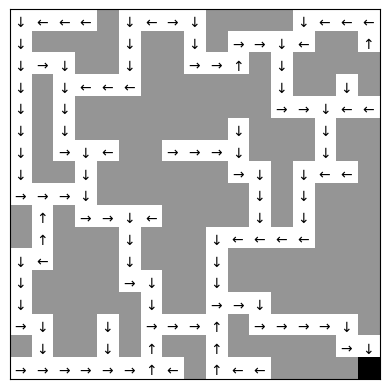

In [725]:
plot_policy(model, default_maze)

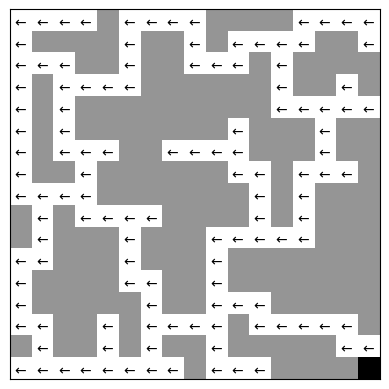

In [698]:
# compare to a default initialized model
plot_policy(NeuralNetwork().to(device), default_maze)

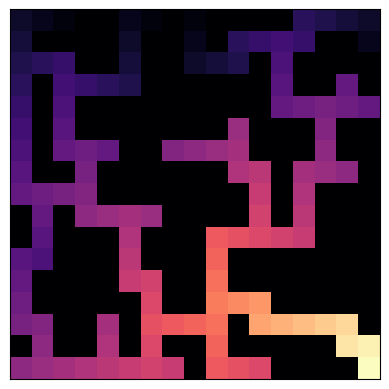

In [750]:
# compute optimal distances to the exit
def dists(maze):
    pos = tuple((maze == -1).nonzero().tolist()[0]) # locate the exit
    dist = torch.zeros_like(maze)
    seen = set()
    q = deque()
    q.append((pos, 0))
    while q:
        pos, d = q.popleft()
        if pos in seen: continue
        if maze[pos] == 0: continue
        seen.add(pos)
        dist[pos] = d
        for move in MOVES.keys():
            new_pos = (pos[0] + move[0], pos[1] + move[1])
            if 0 <= new_pos[0] < MAZE_WIDTH and 0 <= new_pos[1] < MAZE_WIDTH:
                q.append((new_pos, d + 1))
    return dist

def plot_dists(maze):
    dist = dists(maze)
    # revert distances for plotting
    mask = maze != 0
    dist[mask] = dist.max() - dist[mask]
    plt.imshow(dist, cmap='magma', interpolation='nearest')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

plot_dists(default_maze)

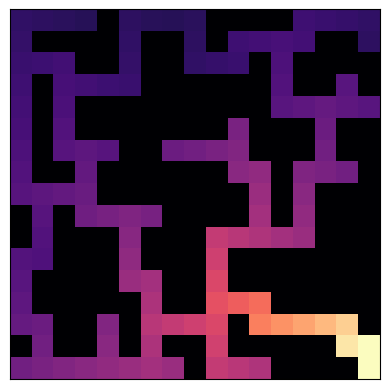

In [749]:
# compute the policy
@torch.no_grad()
def policy_weights(model, maze):
    policy = torch.zeros_like(maze).float()
    positions = (maze == 1).nonzero().tolist()
    for pos in positions:
        pos = tuple(pos)
        q = model(to_input(maze, pos))
        policy[pos] = q.max().item()
    return policy

def plot_policy_weights(model, maze):
    policy = policy_weights(model, maze)
    policy[tuple((maze == -1).nonzero()[0])] = policy.max()
    plt.imshow(policy, cmap='magma', interpolation='nearest')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

plot_policy_weights(model, default_maze)

In [690]:
# backup to disk
# --------------
# torch.save(model.state_dict(), 'maze-17x17.pt')

# load from disk
# --------------
# m = NeuralNetwork()
# m.load_state_dict(torch.load('maze-17x17.pt'))